# WDL 2021 - Stage 3: Predicting the demand for shared bicycles

# Introduction

Heavy traffic is associated with air pollution, safety risks, and losses in terms of accessibility, sustainable growth, and social cohesion. In order to overcome these problems, one of the main goals of the European transport policy is to promote more sustainable modes of transportation. [1] [2] 

Our cities must evolve to become more environmentally friendly, thus reducing the negative impact on our planet. According to [3], bicycles are one of the most sustainable modes of urban transport, thus not having any negative impact n the environment, and even promotes physical activity and improves health. Moreover, it's suitable for short and médium distance trips and is cost-effective from the perspective of users and infrastructure.

Over the last few years, the popularity of public bike-sharing systems has increased so much that more than 60 countries already have these types of systems implemented. Bike-sharing systems allow users to travel in the city at a low cost and with ease of loan a bicycle at one station and leave it at another. [3]

This type of system is already changing and becoming more effective since most of them are equipped with sensors capable of giving information to users. However, regarding resources management, there are still some problems associated with it and which limit its use. [3] If, on the one hand, the use of a shared bicycle allows the user to reduce waiting time in transit and searching for parking, on the other hand, the management of bicycles has some problems that the user may have to wait in a station until there is a vacant dock [3].

Nowadays, some of the solutions that are being studied are related to predicting the demand of bicycles and, subsequently, station administrators notification, that allows them to identify which stations should be close down and where to set up more stations. It should also be noted that in many of these studies, weather conditions, events, time of day, and day of the week are considered factors with a high influence on the use or not of shared bicycles, so we’ll also look at some of these. [3] [4] [5]

**(VER C Fábio e Bruno)**

Our first approach was to make the tracking of each bike and thus understand which stations would be with the docks all full and which ones would be empty so that the bikes were moved from one station to another. However, as the bike id changes throughout the year, this would not be possible.

We had to modify our solution, however, the goal of helping the problem mentioned above, the existence of periods of time at certain stations in which users have to wait or move to another station to find an available dock, remains.

To overcome this problem our solution, (...).

# Data pre-processing

When analyzing the data, from the beginning there was a large amount of information that made it difficult to process, so some decisions were made:
- the selected data refers to the years of 2016, 2017, 2018 and 2019. It was found that the data comprised 2014 and 2021, which we considered to be a very large window. Thus, data prior to 2016, since they are from a long time ago and because they have a smaller amount of data (2014 - 210880 and 2015 - 1161752) and after 2020, due to the coronavirus, were removed.
- rows of important columns with NaN values are removed.  
- only durations longer than 1 min are considered. From the calculation of the bicycle usage duration, some anomalies were verified, such as the date of fecha_devolucion being before fecha_prestamo (negative duration) and durations of less than 1min, for which reason all these data were removed.

In order to avoid the repetition of preprocessing, the preprocessed data was previously saved. Thus, sections 3.3 and 3.4 can be ignored and in section 4 the cleaned dataframe is used for analysis.

## Import libraries and customize seaborn

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import floor, sin, cos, sqrt, atan2, radians, asin
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
import folium
from itertools import combinations
import networkx as nx

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

base = '/home/ana/Downloads/'
#base = '/home/bsilva/Desktop/'
#base = r'C:\Users\Carolina Alves\OneDrive - Universidade de Aveiro\WDL competition\Stage 3\'

Using TensorFlow backend.


## Auxiliar functions

In [2]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

## Loading the dataset

In [ ]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
df = pd.read_csv(base+'/'+"bike_loans.csv", sep=";")
pickle.dump(df, open(base+'/'+"df_raw", "wb"))

In [ ]:
# Opening data
df = pickle.load(open(base+'/'+"df_raw", "rb" ))

In [ ]:
df.head()

In [ ]:
df.shape

## Data types, uniques and NaN information 

**Checking type of data, number of unique values and the presence of missing values**

In [ ]:
def eda_to_df(df):
    header="+" + ("-"*85) + "+"
    form = "|{:^25s}|{:^10s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)) )) # %NaN
    print(header)

eda_to_df(df)

Regarding Type, Id_Tag_Bicicleta and operario are two columns where the type is an object and where we intend to encode the features. Fecha_Prestamo and Fecha_Devolucion are also an object, however, we will not encode them, since they are related to dates and hours.

Looking up to the uniques, stands out the fact that Id_Aparcamiento_Origen and Id_Aparcamiento_Destino don't have the same counts and that the columns Importe and DescripcionImporte only have one value that is why we removed them.

Lastly, there are a lot of columns with NaN values. The one that we highlight is Id_Aparcamiento_Destino because if there is no information from the destination station then this information must be deleted.

**Removing Importe and DescripcionImporte**

In [ ]:
df = df.drop(['Importe', 'DescripcionImporte'], axis=1)

**Removing NaN values from Id_Aparcamiento_Destino**

In [ ]:
df = df[df['Id_Aparcamiento_Destino'].notna()]

**Calculating the usage duration of bicycles**

In [ ]:
def duration (prestamo, devolucion):

    start = datetime.datetime.strptime(prestamo[0:19], "%Y-%m-%d %H:%M:%S")
    end = datetime.datetime.strptime(devolucion[0:19], "%Y-%m-%d %H:%M:%S")
    time = end - start
    seconds = time.total_seconds()

    return seconds

In [ ]:
df['Duration'] = df.apply(lambda x: duration(x['Fecha_Prestamo'],x['Fecha_Devolucion']),axis=1)

**Removing data when the usage duration of bicycles is negative (which means that the day of prestamo is after the day of devolucion) and less than one minute(60 seconds)**

In [ ]:
df = df[df['Duration']>60]

**Removing data before 2016 and after 2020**

In [ ]:
def select_data_between(df, year_init, year_end):

    df_list = []
    increment = 1000000
    for i in range(0,15000000, increment):
        df_ = df.iloc[i:i+increment,:]
        #creating column with the year of prestamo and devolucion
        df_['Year_Prestamo'] = df_.apply(lambda x: year_(x['Fecha_Prestamo']),axis=1) 
        df_['Year_Devolucion'] = df_.apply(lambda x: year_(x['Fecha_Devolucion']),axis=1) 
        #removing years before year_init and after year_end
        df_= df_[(df_['Year_Prestamo']>=year_init) & (df_['Year_Prestamo']<year_end)]
        df_= df_[(df_['Year_Devolucion']>=year_init) & (df_['Year_Devolucion']<year_end)]
        df_list.append(df_)

    #creating cleaned dataframe
    df_new_ = pd.DataFrame()
    df_clean_ = df_new_.append(other=df_list,ignore_index=True)

    return df_clean_

df_clean_ = select_data_between(df, 2016, 2020)

#confirming
print(df_clean_['Year_Prestamo'].unique())
print(df_clean_['Year_Devolucion'].unique())

**Encoding categorical features: Importe and DescripcionImporte**

In [ ]:
print('Number of NaN in column Id_Tag_Bicicleta: ', df_clean_['Id_Tag_Bicicleta'].isnull().sum())
print('\nNumber of NaN in column operario: ', df_clean_['operario'].isnull().sum())

In [ ]:
operario_ = df_clean_['operario'].fillna(value='other')
df_clean_['operario'] = operario_

In [ ]:
enc, df_clean_ = encode_categorical_features(df_clean_, ["Id_Tag_Bicicleta", "operario"])
df_clean_.head()

In [ ]:
#Saving cleaned dataframe
pickle.dump(df_clean_, open(path+'/'+"df_clean", "wb" ))

# Exploratory Data Analysis

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    df['ID end station'] = df['ID end station'].astype(int)
    df['ID start station'] = df['ID start station'].astype(int)
    
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df["End loan"] = pd.to_datetime(df["End loan"], format='%Y-%m-%d %H:%M:%S.%f')
    
    # Auxiliar fields
    df['year_prestamo'] = df["Start loan"].dt.year
    df['month_prestamo'] = df["Start loan"].dt.month
    df['day_prestamo'] = df["Start loan"].dt.day
    df['hour_prestamo'] = df["Start loan"].dt.hour
    
    df['year_devolucion'] = df["End loan"].dt.year
    df['month_devolucion'] = df["End loan"].dt.month
    df['day_devolucion'] = df["End loan"].dt.day
    df['hour_devolucion'] = df["End loan"].dt.hour
    
    df['duration_hour'] = (df["End loan"]-df["Start loan"]).dt.total_seconds().div(60*60)
    df['Fecha_Prestamo_htruncate'] = df['Start loan'].dt.floor('h')
        
    return df

df = get_loans_clean(base)
df.head()

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end,year_prestamo,month_prestamo,day_prestamo,hour_prestamo,year_devolucion,month_devolucion,day_devolucion,hour_devolucion,duration_hour,Fecha_Prestamo_htruncate
0,6501462,18701,1164,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43,1.0,2017,6,21,14,2017,6,21,14,0.271667,2017-06-21 14:00:00
1,6501318,41811,1089,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54,NaN,2017,6,21,14,2017,6,21,14,0.530000,2017-06-21 14:00:00
2,6501489,96620,1110,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9,13.0,2017,6,21,14,2017,6,21,14,0.232222,2017-06-21 14:00:00
3,6501001,16055,1465,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9,6.0,2017,6,21,13,2017,6,21,14,1.058333,2017-06-21 13:00:00
4,6501421,6431,996,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54,NaN,2017,6,21,14,2017,6,21,14,0.358333,2017-06-21 14:00:00


## Analysis using External Data

### Stations location

In [4]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','Description', \
                'numSlots','isManual', 'Lat', 'Lon']]

def convert_coord_to_number(coord_str):
    return float(coord_str.replace(',', '.'))

df_info['Lat'] = df_info['Lat'].apply(lambda x : convert_coord_to_number(x))
df_info['Lon'] = df_info['Lon'].apply(lambda x : convert_coord_to_number(x))

df_info.head()

,ID,Description,numSlots,isManual,Lat,Lon
0,1,Moravia,15,1,6.276585,-75.564804
1,2,Universidad,33,1,6.269267,-75.565300
2,3,Ruta N,40,0,6.265182,-75.566348
3,4,Punto Cero,10,1,6.265161,-75.575066
4,5,Universidad Nacional,33,1,6.259663,-75.578812


**Showing stations in the map**

In [5]:
plt.show()
# Helper function to draw street blocks on map
def add_marker(map, station_name, lat, long):
    folium.Marker(location=[float(lat), float(long)], popup=station_name).add_to(map)   

#initiate map in medelín
m=folium.Map(location=[6.2427031074310175, -75.49371702640158], zoom_start=12)

#draw the street blocks on the map with a color and assign them to a group
df_info.apply(lambda l: add_marker(m, l['Description'],l['Lat'], l['Lon']),axis=1)

m

From a wider perspective, two regions of bicycle stations stand out. 

When looking with less zoom, the region below is divided into three zones that correspond to 3 different cities that belong to the Valle de aburrá: Sabaneta, Itaguí, and Envigado.

The uppermost region is located in the city of Medelín, which is the most important and largest in the Valle, so it makes perfect sense to be the one with the largest number of stations.

The cities of Caldas, La Estrella, Bello, Copacabana, Girardota, and Barbosa, according to the data, do not have stations, which may be necessary to create shared bicycle systems in these areas.

**Checking the storage capacity of automatic stations**

* What are the automatic stations with the largest and smallest storage capacity?

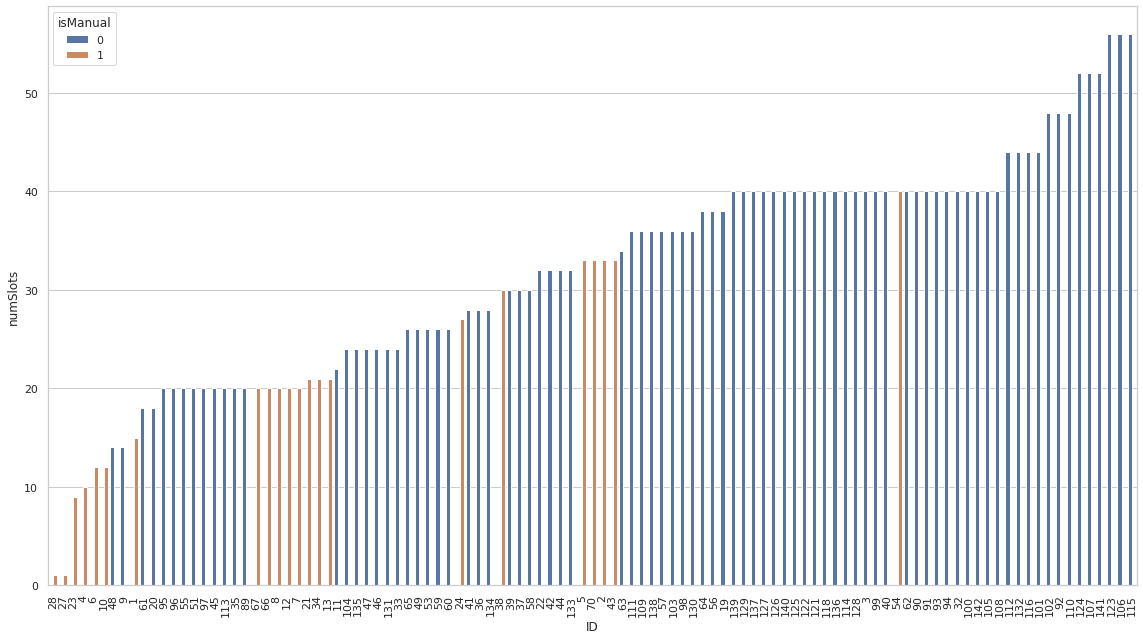

In [6]:
def capacity_per_station(_df):
    df = _df.copy()
    df["ID"] = df["ID"].astype(str)
    df = df.sort_values(by=['numSlots'])
    
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x="ID", y="numSlots", hue="isManual", data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.draw()
    
capacity_per_station(df_info)

From the above figure, the number of manual stations is much less than automatic stations. It should also be noted that most of the stations with less storage are manual and the ones with higher storage are automatic.

### Holidays

In [7]:
def get_holidays():
    holidays16 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2016')
    holidays17 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2017')
    holidays18 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2018')
    holidays19 = pd.read_excel('holidays_columbia.xlsx', sheet_name='2019')
    holidays = pd.concat([holidays16, holidays17, holidays18, holidays19])
    return holidays

holidays = get_holidays()
holidays.head()

,DAY,DATE,HOLIDAY
0,Friday,2016-01-01,New Year's Day
1,Monday,2016-01-11,Epiphany
2,Monday,2016-03-21,Saint Joseph's Day
3,Thursday,2016-03-24,Maundy Thursday
4,Friday,2016-03-25,Good Friday


          DATE  count      DAY             HOLIDAY
17  2018-08-08  11666   Monday            Epiphany
9   2017-08-15   9011  Tuesday  Assumption of Mary


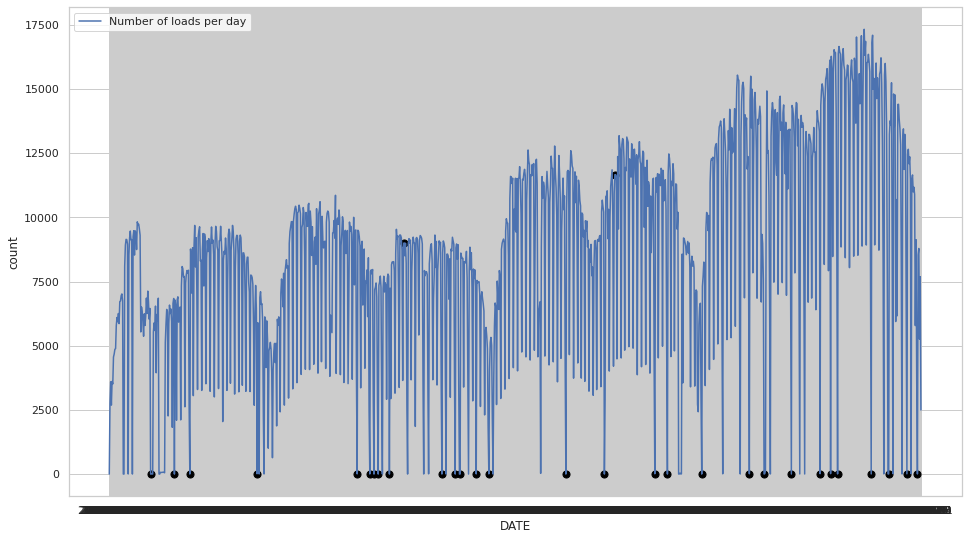

In [8]:
def plot_loans_per_day_versus_holidays(_df, holidays):
    df = _df.copy()
    df['DATE'] = df['Start loan'].dt.date.astype(str)
    dfDATE_count = df.groupby('DATE').size().reset_index(name='count')
    
    holidays_count = pd.merge(dfDATE_count,holidays,on='DATE')
    
    print(holidays_count.sort_values(by='count', ascending=False).head(2))

    fig, ax = plt.subplots(figsize=fig_dim)
    
    sns.lineplot(data=dfDATE_count, x='DATE',y='count', ax=ax, label="Number of loads per day")
    sns.regplot(data=holidays_count, x="DATE", y="count", fit_reg=False, 
                scatter_kws={"color":"black","alpha":1,"s":50}, ax=ax, label='Holidays')
    
plot_loans_per_day_versus_holidays(df, holidays)

Analyzing the graph of daily counts over the years with the holidays, we can see the great influence of the holidays on the data. 

Most of the days, when the count is very low, coincide with the holidays, standing out only two days when the number of users is high, which refer to holidays x and y. Since most stations are automatic, it is more likely that stations close on holidays.

### Weather

In [9]:
def get_history(city_name, start_date):
    
    print("Retrieving {0} history...".format(city_name))
      
    api = "155b4d6acbf49ae8044c54f654953578"
    start = str(int(time.mktime(datetime.datetime.strptime(start_date, "%Y-%m-%d").timetuple())))
    
    url = "http://history.openweathermap.org/data/2.5/history/wdl?q=" + city_name + ',CO&type=hour&start=' + start + '&cnt=24&appid=' + api \
        
    request_json=requests.get(url).json()   
    
    return pd.json_normalize(request_json["list"])

In [10]:
def get_agg_metric(city, start_date, col, agg_metric):
    df=get_history(city, start_date)
    #metric = df[col].agg_metric
    
    #return metric
    return df.agg({col: agg_metric})

Selecting data from 2018 and 2019 and counting the daily number of bicycle usage.

In [ ]:
df['DATE'] = df['Start loan'].dt.date.astype(str)
df = df[(df['year_prestamo']>=2018)]

In [ ]:
dfDateCount = df.groupby(['DATE','year_prestamo','month_prestamo','day_prestamo']).size().reset_index(name='count')

In [ ]:
dfDateCount['AvgDailyTemp'] = dfDateCount.apply(lambda row: get_agg_metric("Itagui", row.DATE, "main.temp", "mean"), axis=1)
dfDateCount['AvgDailyPressure'] = dfDateCount.apply(lambda row: get_agg_metric("Itagui", row.DATE, "main.pressure", "mean"), axis=1)
dfDateCount['AvgDailyHumidity'] = dfDateCount.apply(lambda row: get_agg_metric("Itagui", row.DATE, "main.humidity", "mean"), axis=1)
dfDateCount['AvgDailyWind'] = dfDateCount.apply(lambda row: get_agg_metric("Itagui", row.DATE, "wind.speed", "mean"), axis=1)

In [ ]:
#saving dataframe with weather data
pickle.dump(dfDateCount, open(base+'/'+"df_weather", "wb"))

In [11]:
#acessing dataframe with weather data
dfDateCountWeather = pd.read_pickle(base + '/' + 'df_weather')

In [12]:
def correlation_matrix (df):
    cor = df.corr()
    
    fig,ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cor, annot=True)

**Daily Analysis**

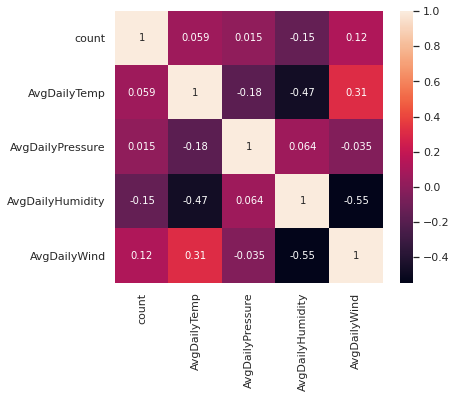

In [13]:
correlation_matrix(dfDateCountWeather.filter(['count', 'AvgDailyTemp', 'AvgDailyPressure', 'AvgDailyHumidity', 'AvgDailyWind']))

The number 



TROCAR ORDEM PARA DEPOIS DA PARTE EM QUE FAÇO BALANÇO E VER A RELAÇÃO DO BALANÇO VERSUS DADOS METER.

# Evolution over time versus loans????

## Evolution of loans, returns, stations... over time

**What are the most common hours / days of the week / months for using shared bicycles?**

In [ ]:
def plot_prestamo_over_time(_df):
    df = _df.copy()
    
    fig, axs = plt.subplots(2, 2, figsize=fig_dim)
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
    
    time_units = ["year", "month", "day", "hour"]
    
    for i in range(len(time_units)):
        time_unit = time_units[i]
        df_time = df.groupby(time_unit+'_prestamo').size().reset_index(name='count')

        axis[i].plot(df_time[time_unit+"_prestamo"], df_time["count"])
        axis[i].set_title(time_unit+"_prestamo")

    plt.plot()

plot_prestamo_over_time(df)

Over the years there has been an increase in the use of shared bicycles, which proves the efforts made so that more and more sustainable transports are used.

Regarding the months throughout the year, there are some that stand out for the greater volume of loans, namely August, September, and October. This may be due to the fact that they correspond to the times with the greatest number of tourists. They are followed by February, March, July, and November, where there is also a high number of loans. The months with the lowest use of bicycles are January, June, and December. The fact that January and December have such low numbers may be related to the weather conditions (heavy rain) that lead to the non-use of bicycles.

Over the days of the month, the values are similar, with small fluctuations. For the 31st day, there is a great decrease, this is due to the fact that a smaller number of months has 31 days.

Throughout the day, there are two peaks that stand out and that coincide with the rush hour (one in the early morning and the other in the late afternoon). There is also a peak at lunchtime. These three moments of the day are the busiest because they include traveling home-work, work-home, and even traveling to lunch. It is also possible to identify approximately the opening and closing times of the stations, 4 am and 10 pm, respectively.

**What are the average loan times?**

In [ ]:
dfDuration = df.groupby('duration_hour').size().reset_index(name='count')
dfDuration_ft = dfDuration[(dfDuration["duration_hour"]<3) & (dfDuration["duration_hour"]>0.05)]
ax=dfDuration_ft.plot(x="duration_hour", y="count", figsize=fig_dim)

In [ ]:
dfDuration_ft = dfDuration[(dfDuration["duration_hour"]<0.2) & (dfDuration["duration_hour"]>0.05)]
ax=dfDuration_ft.plot(x="duration_hour", y="count", figsize=fig_dim)

As it can be verified, most of the durations of use are less than 1 hour and that the top of the curve is reached between 0.10 and 0.12 of the hour, which means that the most common durations are between 6 and 8 minutes.

**What are the most common origins/destinations?**

In [ ]:
dfOrigin=df.groupby('ID start station').size().reset_index(name='count').sort_values(by=['count'])    
dfOrigin["ID start station"] = dfOrigin["ID start station"].astype(str)
bar_plot("ID start station", "count", dfOrigin)

In [ ]:
dfOrigin[(dfOrigin["ID start station"]=='73') | (dfOrigin["ID start station"]=='105')]

The above graph shows the most common origins.

There are a large number of underused stations, in particular from 73 to 105 (according to the order shown in the graph), with counts less than 1015.

The most used stations, the ones with counts above 300000, are the station 8,7,12,3,2,67 (in descending order). 

In [ ]:
dfDestination=df.groupby('ID end station').size().reset_index(name='count').sort_values(by=['count'])    
dfDestination["ID end station"] = dfDestination["ID end station"].astype(str)
bar_plot("ID end station", "count", dfDestination)

In [ ]:
dfDestination[(dfDestination["ID end station"]=='88') | (dfDestination["ID end station"]=='109')]

The above graph shows the most common destinations.

Again, there are a large number of underused stations, in particular from 88 to 109 (according to the order shown in the graph), with counts less than 1348.

The most used stations, the ones with counts above 300000, are the station 8,7,12,3,67,2,10 (in descending order). 

Relating the counts of the origin and destination stations, it can be seen that the most used ones are common, with 8, 7 and 12 in both being the ones with the highest number.

**What are the most common routes?**

In [ ]:
def plot_popular_routes(df):
    
    df_routes = df.groupby(['ID start station', 'ID end station']).size().reset_index(name='count')
    
    _df_temp = df_routes.copy()
    _df_temp = _df_temp.sort_values(by=['count'], ascending=False).head(6)
    
    print("Max count: ")
    print(_df_temp)

    fig = plt.figure(figsize=fig_dim)
    ax = Axes3D(fig)

    ax.plot_trisurf(df_routes["ID start station"], df_routes["ID end station"], \
                    df_routes["count"], cmap=cm.jet, linewidth=0.2)
    ax.set_zlabel('Count')
    ax.set_xlabel('Origin')
    ax.set_ylabel('Destination')

    plt.show()
    
plot_popular_routes(df)

There are 3 main routes: 8-10, 7-70, and 2-1. The one that is the most common is the 8-10.

[VERIFICAR LOCALIZAÇÃO]

From now on, only the data related to the station of origin will be considered, this is due to the fact that there are destination stations that are never used as an origin and therefore are not informative in our case.

In [ ]:
unique_parks = df['ID start station'].unique()

**For each node, the dates/days and the loans count**

In [ ]:
dfOrigemDayCount=df.groupby(["ID start station", pd.Grouper(key="Fecha_Prestamo_htruncate", freq="D")]) \
                        .size().reset_index(name='Count')
dfOrigemDayCount.head()

[????????]

In [ ]:
# nº de nós associados ao dia
dfNodesDay = dfOrigemDayCount.groupby("Fecha_Prestamo_htruncate").size().reset_index() \
    .rename(columns={0:'count'}).sort_values(by=['count'])

dfNodesDay.tail()

**Daily number of active stations**

In [ ]:
def active_stations_per_day(_df, holidays):
    df = _df.copy().sort_values(by=['Fecha_Prestamo_htruncate'])
    df["Fecha_Prestamo_htruncate"] = df["Fecha_Prestamo_htruncate"].dt.date.astype(str)

    holidays = holidays.rename(columns={'DATE':'Fecha_Prestamo_htruncate'})
    holidays_count = pd.merge(df,holidays,on='Fecha_Prestamo_htruncate')
    
    fig, ax = plt.subplots(figsize=fig_dim)
    sns.lineplot(data=df, x="Fecha_Prestamo_htruncate", y="count", ax=ax, label="Number of loads per day")
    sns.regplot(data=holidays_count, x="Fecha_Prestamo_htruncate", y="count", fit_reg=False, 
                scatter_kws={"color":"black","alpha":1,"s":200}, ax=ax, label='Holidays')
    plt.show()

active_stations_per_day(dfNodesDay, holidays)

Analyzing the figure, we can note again that on the days when there is a holiday, most of the stations, if not all, are closed, hence the number of bicycle usage is quite low.

[??] Meter o nome dos eixos nas figuras
fig, ax = plt.subplots(figsize=fig_dim)
sns.lineplot(data=df, x="Fecha_Prestamo_htruncate", y="count", ax=ax, label="Number of loads per day")

Isto dá-nos a data com mais nós associados mas não garante que os 85 nós tem 4 entradas antes

In [ ]:
def loans_per_day_per_station(_df, station):
    df = _df.copy()
    df = df[df["ID start station"]==station]
    df = df[["Fecha_Prestamo_htruncate", "Count"]]
    
    fig = plt.figure(figsize=fig_dim)
    plt.plot(df["Fecha_Prestamo_htruncate"], df["Count"])

loans_per_day_per_station(dfOrigemDayCount, 1)

In [ ]:
loans_per_day_per_station(dfOrigemDayCount, 70)

The graphs shown above are for two different stations, hence the trend for loans per day is so different. In the first station there is a growing trend, in contrast, in the second station the trend is constant with a great decrease in the months of December and January.

This is just a demonstration of how completely different is the bike usage behavior from station to station.

**Loans per station per hour**

In [ ]:
def get_loans_or_returns_per_station_per_time(_df, field_date, field_station, field_position, time):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    #df[field_date] = df[field_date].dt.round(time)
    
    if time == 'd':
        df[field_date] = df[field_date].dt.date
    elif time == 'h':
        df[field_date] = df[field_date].dt.floor('h')

    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).size().to_frame()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={0:'N Loans'})
    else:
        df = df.rename(columns={0:'N Returns'})
        
    return df

def get_loans_and_returns_info_per_time(_df, time):
    loans = get_loans_or_returns_per_station_per_time(_df, \
                    'Start loan', 'ID start station', 'Position start', time)
        
    returns = get_loans_or_returns_per_station_per_time(_df, \
                    'End loan', 'ID end station', 'Position end', time)
        
    df = pd.concat([loans, returns], axis=1)
    df = df.fillna(0)
    df['balance_per_' + time] = df['N Returns'] - df['N Loans']
    
    return df

In [ ]:
loans_and_returns = get_loans_and_returns_info_per_time(df, "h")
loans_and_returns.head(5)

Above we calculate the balance of each station per hour per day. The balance is calculated by subtracting the number of loans from the number of returns. When there is a negative balance means that the number of loans was greater than the number of returns in that station, at that day, at that hour. When the balance is positive means that the number of returns is greater than the number of loans and when equals to zero, the number of loans is equal to the number of returns.

In [ ]:
# Given a station, this function calculates the number of bikes through time using the loans and the returns
def get_balance_for_station(_df, station):
    df = _df.copy()
    df = df.reset_index()
    df = df.loc[df['Station']==station]
    df['N Loans cumsum'] = df['N Loans'].cumsum()
    df['N Returns cumsum'] = df['N Returns'].cumsum() # returns
    df['Balance'] = df['N Returns cumsum'] - df['N Loans cumsum']
    
    return df

In [ ]:
def plot_balance_over_multiple_stations(loans_and_returns, stations):
    
    fig, axs = plt.subplots(4, 2, figsize=(15,24))
    axis = [ axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1],
             axs[2, 0], axs[2, 1], axs[3, 0], axs[3, 1]]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    
    for i in range(8):
        station = stations[i]
    
        balance_st = get_balance_for_station(loans_and_returns, station)
        
        axis[i].plot(balance_st['Date'], balance_st['Balance'], colors[i])
        axis[i].set_title('Station ' + str(station))
        axis[i].tick_params(labelrotation=30)

    plt.plot()

plot_balance_over_multiple_stations(loans_and_returns, stations=[1, 70, 54, 45, 12, 70, 2, 21])

From the above graphs, there are some stations that receive more than they lend (station 1, 70, 54, 45, 12 and 70), that lend more than they receive (station 2 between 2016-07 and 2018-07) and that receive and lend in the same proportion (station 21 between 2017-07 and 2018-07).

Through the balance it is not possible to understand the initial number of bicycles in the station, because there are several manual changes that are not reported.

[????]

In [ ]:
# TO-DO
# gráfico
# após a previsão encontrar o dia com mais nós em que foi realizada a previsão

**Obtaining the initial number of bicycles per station**

In [ ]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    df = df.rename(columns={'Tag ID':'Count'})
    df = df.sort_values(by=['Count'])
    df = df.reset_index()
    df["ID start station"] = df["ID start station"].astype(str)
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.head()

In [ ]:
init_n_bikes.tail()

We tried to understand what the initial number of bicycles would be per season, however the tag changes should be quite frequent and due to the values obtained, it is not possible to understand the initial number of bicycles of the season. In addition, changes in station bicycles made by workers contribute to this problem, making it impossible to track bicycles over time.

In [ ]:
fig, axs = plt.subplots(figsize=fig_dim)
axs = sns.barplot(x="ID start station", y="Count", data=init_n_bikes)
plt.xticks(rotation=90)
plt.draw()

[dúvida]

The figure above represents the number of bikes that appear for the first time in each station

A estação 9 está associada ao aparecimento pela primeira vez de 400 bicicletas (do ID de uma bicicleta).

[BRUNO] Qual é a localização das estações com mais de 100 contagens? 

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

Ver a taxa de ocupação a cada hora

# Forecasting the ?field?

In [ ]:
#loans_and_returns_per_day = get_loans_and_returns_info_per_time(df, "d")
#loans_and_returns_per_day.head(25)

In [ ]:
def get_max_balance_per_day(_df):
    df = _df.copy()
    df = get_loans_and_returns_info_per_time(df, "h")
    df = df.reset_index()
    df["Date"] = df["Date"].dt.date
    df = df.groupby(['Station', 'Date']).max().rename(
        columns={"N Loans": "max_n_loans", "N Returns": "max_n_returns", "balance_per_h": "max_balance_per_h"})
    df['max_balance_per_h'] = [0 if x<0 else x for x in df['max_balance_per_h']]
    return df
    
loans_and_returns_max_per_day = get_max_balance_per_day(df).reset_index()
loans_and_returns_max_per_day.head()

The data that is selected for each day is the maximum balance per hour, without considering negative values.

In [ ]:
#clean the previous dataset
loans_and_returns_max_per_day = loans_and_returns_max_per_day[['Station', 'Date', 'max_balance_per_h']]
loans_and_returns_max_per_day.Station = loans_and_returns_max_per_day.Station.astype(int)
loans_and_returns_max_per_day.max_balance_per_h = loans_and_returns_max_per_day.max_balance_per_h.astype(int)
loans_and_returns_max_per_day = loans_and_returns_max_per_day.rename(columns={'max_balance_per_h': 'max_balance'})
loans_and_returns_max_per_day

In [ ]:
# ver parâmetros para melhorar, 
# se o count_before for 8 ele dá 8 entradas antes
# offset é o nº de dias antes do atual
# distância entre cada uma das entradas
# distance=1, count_before=3, offset=0 ---> considera os 3 dias antes
# distance=7, count_before=4, offset=7 ---> 4 entradas com a diferença de 7 dias entre elas 
#                                              e começo a contar na semana anterior

In [ ]:
# Auxiliar functions
def generate_features(df, cols, distance=1, count_before=3, offset=0):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance+offset)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance+offset
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], \
                                                               axis=1) 
        
    return periodDf

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test, dfFeatures, col_name):
    trainX = train[dfFeatures.columns[4:]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[[col_name]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[dfFeatures.columns[4:]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[[col_name]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=6, kernel_size=2, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

In [ ]:
def perform_forecasting_all_nodes(_df, parks):
    
    df = _df.copy()

    allNodesDf=pd.DataFrame()
    # CREATE MODEL PER NODE AND PREDICT TEST SET BASED ON EACH INDIVIDUAL MODEL
    for park in parks:
        # FILTERING ENTRIES TO PARK ID
        print ("Filtering entries by park id {}...".format(park))
        dfParkId = df[df["Station"]==park]
        dfParkId=dfParkId.reset_index()
        if len(dfParkId.index) <= 35:  #not enough data for training 
            continue

        # GENERATE FEATURES (4 ENTRIES 7 DAYS APPART FROM EACH OTHER FROM THE PREVIOUS 4 WEEKS)
        print ("Generating park {} features...".format(park))
        dfFeatures=generate_features(dfParkId, ["max_balance"], distance=7, count_before=4, offset=7)
        dfFeatures=dfFeatures.reset_index(drop=True)

        # SPLITTING DF INTO TRAIN AND TEST SETS
        print ("Splitting train/test dataset for park id {}...".format(park))
        train, test = split_df(dfFeatures)
        trainX, trainy, testX, testy = process_df(train, test, dfFeatures, 'max_balance')

        # TRAIN CNN
        print ("Traning model for park id {}...".format(park))
        model, scores = run_experiment(trainX, trainy, testX, testy, repeats=3)

        # PREDICT TEST SET SAMPLES
        print ("Predicting samples for park id {}...".format(park))
        predict = model.predict(testX)
        dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
        truth=pd.DataFrame(data=testy[:], columns=["truth"])
        testDf=pd.concat([dfPredict, truth, test.reset_index()[["Station", "Date"]]], \
                         axis=1)
        testDf.set_index(["Station", "Date"], inplace = True)
        allNodesDf=pd.concat([allNodesDf, testDf])
        print(allNodesDf)
        
    return allNodesDf


#allNodesDf = perform_forecasting_all_nodes(loans_and_returns_max_per_day, [8, 56])
allNodesDf = perform_forecasting_all_nodes(loans_and_returns_max_per_day, unique_parks) #<<---- demora muito tempo (~20 mins)

## Overall results

In [ ]:
rms = np.sqrt(mean_squared_error(allNodesDf["truth"], allNodesDf["predict"]))
print ("OVERALL ROOT MEAN SQUARED ERROR >> " + str(rms))
max_charts = 4
i = 0
for node in unique_parks:
    i+=1
    print (" ------------------ NODE {} TRUTH VS PREDICTED CHECK INS ------------------ ".format(node))
    ax=allNodesDf.loc[node].plot(figsize=fig_dim, title='Predicted vs ground truth max loans/returns of bicycles per day and station (for test set)')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Max loans/returns of bicycles")
    plt.show()
    if i == max_charts:
        break

These results are not great but are sufficient for the next step: Load balancing.
One way to improve these results would be explore feature generation and perform hyperparameter tuning, which we did not explore to focus on other spects of this work.
(elaborar mais..)

# Load Balancing

We will use a graph to perform load balacing between nodes. Our method is the following:
 - Compute the distance in km between every station
 - Build a graph where the nodes are stations and edges have the distance between the stations
 - Check if, for a given station, it can fulfill the maximum demand for bicycles for the day, if it cannot than do the following:
     - Perform Breadth First Search in order to find nodes from which we can extract nodes without compromising the demand capacity for that station
     - When we find a node from which we can take some, or all necessary bicycles to the needed station we extract what bicycles we can
     - Continue visiting other nodes until we have allocated all needed bicycles for the needed station

Because we were not able to correctly calculate the number of bicycles per stations with the given data we had to use another metric to use load balacing. Our idea was to search for the balace between the loaned bikes and returned and consider the maximum value. For instance, if a station had a maximum balance of bikes of 30, but its capacity is only 20, that station requires 10 more bicycles. In other words, we try to look at maximum peak value in a given hour of the day where the most bicycles are needed and ensure that a given station can fulfill that demand.

First, we will prepare the data for the load balacing. The previous predicted nodes have previsions for distinct days. We will select a day for which we have more previsions and consider only the nodes that have predicted data for that day for the load balacing

In [ ]:
allNodesDf = allNodesDf.reset_index()
allNodesDf.predict = allNodesDf.predict.round().astype(int) #round up predictions
allNodesDf.head()

In [ ]:
dfNodesDay = allNodesDf.groupby("Date").size().reset_index() \
    .rename(columns={0:'count'}).sort_values(by=['count'])

dfNodesDay.tail()

2019-12-30 is the date where we have more predicted nodes, so we will do load balacing for that day

Now, for the construction of the graph

In [ ]:
## Auxiliar functions to prepare the data for the load balancing

def get_coord_by_station_id(station_id):
    lat = df_info.loc[df_info['ID'] == station_id, "Lat"].iloc[0]
    lon = df_info.loc[df_info['ID'] == station_id, "Lon"].iloc[0]
    return [lat,lon]

def get_station_capacity_by_id(station_id):
    return df_info.loc[df_info['ID'] == station_id, "numSlots"].iloc[0][0]

def get_station_demand_by_id(date, station_id):
    return allNodesDf.loc[(allNodesDf['Station'] == station_id and allNodesDf['Date'] == date),\
                          "predict"].iloc[0]

def get_demand_prediction_on_station_and_day(day, station_id):
    return allNodesDf.loc[(allNodesDf['Station'] == station_id) & (allNodesDf['Date'] == day),\
                          "predict"].iloc[0]

#calculate distance between 2 geographic points having into account a round globe
#code adapted from: https://stackoverflow.com/a/4913653
def haversine(p1, p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [p1[1], p1[0], p2[1], p2[0]]) #long, lat CONFIRM ORDER!!!!
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [ ]:

#Compute the distance in KM for each pair of stations (e.g.: station id 1 and station 
#id 2 have a distance of 0.82km)
def compute_distances(station_list):
    for comb in combinations(station_list, 2):
        p1_coordinates = get_coord_by_station_id(comb[0])
        p2_coordinates = get_coord_by_station_id(comb[1])
        station_dist[comb] = haversine(p1_coordinates, p2_coordinates)
    return station_dist


#Create a graph where the nodes are the stations and the edge contains the distance in km between stations.
#We only create a connection (edge) between two stations if their distance is below a certain threshold.
def create_graph_for_load_balancing(station_list, station_dist, date, distance_treshold=1.5):
    G = nx.Graph()
    #create nodes for each station id, with information regarding its predicted demand for the day, and ....
    for station in station_list:
        G.add_node(station, max_balance=get_demand_prediction_on_station_and_day(date,station),\
                        capacity=get_station_capacity_by_id(station))

    for stations, distance_km in station_dist.items():
        if distance_km <= distance_treshold:
            G.add_edge(stations[0], stations[1], distance=distance_km)
    return G

def create_graph(station_list, day_for_balancing, distance_treshold=1.5, print_graph=True):
    station_dist = compute_distances(station_list)
    G = create_graph_for_load_balancing(station_list, station_dist, day_for_balancing, distance_treshold)
    if print_graph:
        #Visualize the graph (although may be very dense as there may be several stations)
        #Note: will probably throw an error. To fix it, downgrade "decorator" version by doing: pip install decorator==4.3
        nx.draw(G, node_size=30, with_labels=False)
    return G


#code adapted from: https://www.educative.io/edpresso/how-to-implement-a-breadth-first-search-in-python?fbclid=IwAR1ilvYjxbiM87oikNNzymT-9jrOLsDGlISOuFv2DgFH9wjLsLv4vqtiqBo
#perform breadth first search from a starting node. Visit nodes until we can allocate bicycles to the original station
def bfs_load_balancing(graph, station):
    
    if G.nodes[station]['capacity'] >= G.nodes[station]['max_balance']:
        print("Station has enough bicycles to fulfill demand. No load balancing needed.")
        return
    
    visited = [] # List to keep track of visited nodes.
    queue = []     #Initialize a queue
    
    bycicles_needed = G.nodes[station]['max_balance'] - G.nodes[station]['capacity']
    print(str(station) +" has a predicted maximum balance of "+str(G.nodes[station]['max_balance'])+\
          " but only a capacity of "+str(G.nodes[station]['capacity']) + ". "+str(bycicles_needed)+' needed.')
    visited.append(station)
    queue.append(station)

    while queue:
        s = queue.pop(0) 
        #check if this node has enough capacity
        if s != station and G.nodes[s]['capacity'] > G.nodes[s]['max_balance']:
            #take all or some bicycles from this station such that it does not surpass
            available_bics = G.nodes[s]['capacity'] - G.nodes[s]['max_balance']
            if bycicles_needed > available_bics:
                bics_taken = available_bics
                #update node info on the original station and station from which we took bics from   
                nx.set_node_attributes(G, {s:{'capacity':G.nodes[s]['capacity']-bics_taken}})
                nx.set_node_attributes(G, {station:{'capacity':G.nodes[station]['capacity']+bics_taken}})
                #update bics needed
                bycicles_needed = bycicles_needed - bics_taken
                print("Taken "+str(bics_taken)+" bicycles from "+str(s)+". Need more "+str(bycicles_needed)+" for "+str(station))
                #visit other nodes
            else:
                #We can take all needed bics from this station
                #update node info on the original station and station from which we took bics from   
                nx.set_node_attributes(G, {s:{'capacity':G.nodes[s]['capacity']-bycicles_needed}})
                nx.set_node_attributes(G, {station:{'capacity':G.nodes[station]['capacity']+bycicles_needed}})
                print("Taken "+str(bycicles_needed)+" bicycles from "+str(s)+". All necessary bics given to "+str(station)+". \n Complete.")
                #end here
                return
                
        #get neighbour nodes
        neighbour_nodes = [n for n in G.neighbors(s)]
        
        for neighbour in neighbour_nodes:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)


Previous functions offer an implementation for out load balancing. We choose to use a graph because we find it to be the most suitable data structure to keep track of connections between stations. Our algorithm attempts to visit the closest stations first and take bicycles from those visited stations that will not be needed and such that each station can still answer to their own demand. We believe that it would be much easier for the company to visit the nearest stations, which is why we do breadh first search, instead of depth first search. 


In [ ]:
day_for_balancing = '2019-12-30'
#get all nodes with prediction for that day
station_list = list(allNodesDf[allNodesDf['Date'] == day_for_balancing].Station.unique())
#not all nodes in the loans dataset are present in stations id. Consider only the stations that are present in both
station_list = list(set(station_list).intersection(df_info.ID.unique()))

G = create_graph(station_list, day_for_balancing, distance_treshold=1.5, print_graph=True)

This is a representation of the graph that will be used for load balacing. There are some stations that were too far away from each other, hence load balancing will consider fewer stations to balance. However, the _distance_treshold_ can be increased if needed in order to create edges between far away stations.  
The stations we will consider for load balacing belong to the densest forest (REVER TERMO), or in other words, were most stations are connected.

In [ ]:
def print_stations_status():
    for k,v in G.nodes(data=True):
        print("station: {0} - capacity={1}, max_balance={2}".format(k, v['capacity'], v['max_balance']))
print_stations_status()

This represents the original status of each station before the load balancing. 

In [ ]:
bfs_load_balancing(G, 1)

In [ ]:
print_stations_status()

We can see the diference in capacity in station 1 and the other stations were the balacing occured.  
Lets see another example

In [ ]:
bfs_load_balancing(G, 10)

In [ ]:
print_stations_status()

### ADICIONAR O BLOCO DE TEXTO EM BAIXO POIS NAO O COLOQUEI LA AINDA

There are of course several improvements that our solution could benefit from. Consider this as a base solution made possible at the best our technical skills and knowldge that can be expanded in several ways. Here are a few limitations/improvements:
- Load balancing is performed, by taking as much bicycles as we can from nearby stations until we have all needed bicycles for a station in need. However, in some cases, the best approach could be to visit a station that is more distant but that can supply all needed bicycles at once.
- Distance between stations is currently calculated using distance between two points, however using street route information to determine their distance would be more accurate.
- ...

# Conclusions

## Scalability and Impact

The data provided was quite extensive and with a large amount of information and although not all of them were analyzed, it was possible to draw some conclusions.

First, from the map with the location of the stations, it was possible to detect two main and distinct zones. Most of the stations are located in the largest city in the Valle de aburrá, the city Medellín, which is the city with the largest number of services, infrastructures, among others, and the most touristic city in the Valle, thus justifying the fact that it has more stations. In addition, it was highlighted that there are some cities in the Valle de aburrá without shared bicycle stations (Caldas, La Estrella, Bello, Copacabana, Girardota, and Barbosa) where there may be a need to create new stations.

Regarding the daily use of bicycles, it was found that in recent years there has been an increasing demand for this type of systems, which is according to what was read in the literature, and that there are months that stand out, August, September, and October, which coincide with the times when there is a greater number of tourists, which suggests that tourists are the biggest users of these systems at these times. Analyzing the number of uses per hour throughout the day, there are two noticeable peak usage corresponding to rush hours, which suggests that users are regular citizens traveling home-work, work-home.

When analyzing the stations separately, it was found that the use of bicycles is totally different, which may be related to the location of the station itself.

Finally, from the analysis with external data (holidays) it was found that in most cases the low number of loans and the open season is due to the fact that it is a holiday.

Regarding the proposed solution, (...)

The data obtained from our solution can benefit station administrators as they become aware of which stations they should move bicycles on, thus making the system more efficient and less hassle for users who had to wait until they find an available dock .

Improving bicycle managing efficieny leads to less people waiting in line to rent/return a bicycle, which makes citizens more willingly to rent a bike, thus reducing traffic flow, contributing for people's wealth, reducing their travelling expenses and finally by reducing air pollution!

## Future Work

Following are some suggestions of analysis that we either could not do with the current data our we did not have enough time to do so:

- We assume that it would be extremely helpful to profile people that use this service in order to better understand their habits and patterns of bicycle usage. Students and workers should be identified as they most likely will loan a bicycle at the start of the day and return it to the same station at the end. Knowing what type of person is renting a bicycly could be extremely helpfull.
- Analyze the impact of nearby public transportations or other services and their impact near close stations. Do these stations have a higher number os bicycle loans?

# References

[1]	“The global bike sharing boom – why cities love a cycling scheme.” https://theconversation.com/the-global-bike-sharing-boom-why-cities-love-a-cycling-scheme-53895.

[2]	N. Boufidis, A. Nikiforiadis, K. Chrysostomou, and G. Aifadopoulou, “Development of a station-level demand prediction and visualization tool to support bike-sharing systems’ operators,” Transp. Res. Procedia, vol. 47, no. 2019, pp. 51–58, 2020, doi: 10.1016/j.trpro.2020.03.072.

[3]	Á. Lozano, J. F. De Paz, G. V. González, D. H. De La Iglesia, and J. Bajo, “Multi-agent system for demand prediction and trip visualization in bike sharing systems,” Appl. Sci., vol. 8, no. 1, 2018, doi: 10.3390/app8010067.

[4]	Y.-H. Seo, S. Yoon, D.-K. Kim, S.-Y. Kho, and J. Hwang, “Predicting demand for a bike-sharing system with station activity based on random forest,” Proc. Inst. Civ. Eng. - Munic. Eng., pp. 1–11, 2020, doi: 10.1680/jmuen.20.00001.

[5]	Y. Pan, R. C. Zheng, J. Zhang, and X. Yao, “Predicting bike sharing demand using recurrent neural networks,” Procedia Comput. Sci., vol. 147, pp. 562–566, 2019, doi: 10.1016/j.procs.2019.01.217.